# microCOSM Model ensemble

<img src="microCOSM_schematic_4box.png" width="350" />

The _microCOSM_ model has three boxes linked by an overturning circulation: a cool, fresh, upwelling box with low iron input analagous to HNLC regions like the Southern Ocean, and a warmer, salty, deep water formation region with significant iron input analagous to the Atlantic Ocean. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

In this notebook, we run two groups of simulations looking at the response of the global carbon cycle to changes in overturning circulation strength, additionally considering the effects of constant, fixed iron-ligand concentrations and dynamic ligand cycling.

In [111]:
import glob               as gb
import matplotlib         as mp
import numpy.ma           as nm
import numpy              as np
import matplotlib.pyplot  as plt
import pandas             as pd
import scipy.stats        as st
import time
import warnings           as ws

from matplotlib.ticker                     import FormatStrFormatter
from matplotlib.patches                    import Rectangle, Arc, RegularPolygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Some figure options for later
mp.rcParams["xtick.labelsize"] = 14
mp.rcParams["ytick.labelsize"] = 14


def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import os
    import subprocess

    # Depending on platform
    if os.sys.platform == "darwin":
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform

        mac_ver = ".".join(platform.mac_ver()[0].split(".")[:2])
        env     = dict(os.environ, **{"MACOSX_DEPLOYMENT_TARGET": mac_ver})
        print("setting MACOSX_DEPLOYMENT_TARGET to: " + mac_ver)
    else:
        env     = os.environ

    optdefs     = "OPTIONDEFS = "
    if options is not None:
        optdefs = optdefs + " ".join(["-D" + item for item in options])
        print("Compiling with options: " + optdefs)

    # Clean environment of previous model files
    runmake = subprocess.Popen(
        ["make", "clean"],
        stdin  = subprocess.PIPE,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text   = True,
        env    = env,
    )
    runmake.wait()
    # Compile
    runmake = subprocess.Popen(
        ["make", "pymodel", optdefs],
        stdin  = subprocess.PIPE,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text   = True,
        env    = env,
    )
    runmake.wait()
    print("The exit code for compilations was: {0}".format(runmake.returncode))
    return runmake.returncode


def check_parallel():
    import importlib

    spec            = importlib.util.find_spec("pandarallel")
    run_in_parallel = spec is not None
    return run_in_parallel

def label_axes(axarray,ignore=None,label_columns=False):
    import string      as st
    m=0
    
    if label_columns:
        axarray=np.transpose(axarray)
    
    for n, ax in enumerate(axarray.flat):
        if ignore is not None and n in ignore:
            m+=1
            continue
        else:
            ax.text(-0.05, 1.05, st.ascii_uppercase[n-m], transform=ax.transAxes, 
                    size=20, weight='bold')


## 1. Run a small ensemble in parallel to examine sensitivity
It's possible to use _microCOSM_ to perform efficient ensemble/parameter space exploration (potentially in parallel using the "Pandarallel" package's "parallel_apply" function). This separate notebook is necessary because you cannot 'reload' f2py extension modules

First, recompile the model to allow variable atmospheric pCO$_2$ (sometimes this seems to just hang?)

In [112]:
ec = compile_microcosm(options=["FOURBOX"])

if ec == 0:
    import microCOSM

setting MACOSX_DEPLOYMENT_TARGET to: 12.5
Compiling with options: OPTIONDEFS = -DFOURBOX
The exit code for compilations was: 0


Define some driver functions for running the ensemble

In [113]:
def run_microcosm(df_input, workers=1, Rcp=106, Rnp=16):
    """
    Run the box model:

    a) workers=1; in series using pandas' "apply" to run through rows of a data frame of inputs
    b) workers>1; in parallel using pandarallel's "parallel_apply"

    returns pandas dataframe with the results
    """
    # Define private helper function, pretty much the same as the direct model call in "run_microCOSM" notebook
    def _boxmodel(self):
        timeseries = pd.DataFrame(
            np.column_stack(
                microCOSM.mod_modelmain.model(*self.values),
                            ).T,
                            index=[
                          "time",
                          "taa","tso","tna","tdo",
                          "saa","sso","sna","sdo",
                          "caa","cso","cna","cdo",
                          "aaa","aso","ana","ado",
                          "paa","pso","pna","pdo",
                          "naa","nso","nna","ndo",
                          "faa","fso","fna","fdo",
                          "laa","lso","lna","ldo",
                          "exportaa","exportso","exportna","exportdo",
                          "lim",
                          "pstar",
                          "pco2aa","pco2so","pco2na","pco2do",
                          "atmpco2",
                                    ],
                              ).transpose()

        # return the last timestep of model run, as well as input parameter values
        return pd.concat(
                [
                    self[["niter",
                          "nyrs",
                          "tout",
                          "nout",
                          "psi",
                          "dif",
                          "alphabio",  
                          "gamma",     
                          "lambda",    
                    #      "dlambdadz", 
                    #      "sourceFe",  
                    #      "wind",      
                    #      "fopen",
                         ]],
                    timeseries.iloc[-1].drop(columns=["time"]),
                    ]
                    )   

    if workers == 1:
        # Run in serial mode (avoids overhead of pandarallel if not running multiprocessor)
        df_output = df_input.apply(_boxmodel, axis=1)
    elif workers > 1:
        # Run in parallel
        from pandarallel import pandarallel

        pandarallel.initialize(nb_workers=workers, progress_bar=True)

        df_output = df_input.parallel_apply(_boxmodel, axis=1)

    # Do some post processing
    df_output = postprocessing(df_output, Rcp=Rcp)

    return df_output


# example post processing routine
def postprocessing(data_pd, Rcp=106):
    # Integrated export production (Southern Ocean + North Atlantic)
    data_pd["tot_export"] = data_pd["exportaa"]\
                           +data_pd["exportso"]\
                           +data_pd["exportna"]
    return data_pd

Set up the model ensemble investigating how the strength of the overturning circulation affects atmospheric CO$_2$ levels. First, we'll start with fixed and homogenous ligand concentrations.

In [114]:
# Box names
names   = {
    "AA":"Antarctic Zone",
    "SO":"Southern Ocean",
    "NA":"North Atlantic",
    "DO":"Deep Ocean"
    }

# Name mangling to get the right pickup
fadd    = "4box"
fnadd   = fadd + "fixedlt2nm"

load_previous_results=True

if load_previous_results:
    # Set psi max
    psi_max = 80.0
    # psi_max=320.

    ensemble1_input = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd,psi_max), 
    )
else:
    # Set psi max
    psi_max = 80.0
    # psi_max=320.

    # Number of experiments to run
    niters  = 41
    # niters = 65
    niter   = np.arange(niters)
        
    # Load steady state values from before
    model_input = pd.read_json(
        "run_microCOSM_{0}_pickup.json".format(fnadd), 
        typ='series'
    ).to_frame()
    
    # change overturning circulation by 2Sv between 0 and 40Sv
    psi_var     = np.linspace(0.0, psi_max, niters) * 1e6
    
    # repeat the input parameters and adjust for the ensemble run
    ensemble1_input = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)
    
    ensemble1_input["nyrs"]   = 1e4
    ensemble1_input["tout"]   = 10
    ensemble1_input["nout"]   = int(ensemble1_input["nyrs"].iloc[0]/ensemble1_input["tout"].iloc[0])
    ensemble1_input["psi"]    = psi_var
    ensemble1_input["niter"]  = niter
    
    ensemble1_input.to_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd,psi_max),
    )

ensemble1_input.iloc[0]

niter                                                         0
nyrs                                                      10000
tout                                                         10
nout                                                       1000
dx             [17000000.0, 17000000.0, 17000000.0, 17000000.0]
dy               [1000000.0, 3000000.0, 12000000.0, 16000000.0]
dz                                   [50.0, 50.0, 50.0, 5050.0]
depth                                [25.0, 25.0, 25.0, 2575.0]
latitude                          [-84.375, -61.875, 22.5, 0.0]
Kmix          [[0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0], [...
Rremin        [[-1.0, 0.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0],...
Pcir          [[0.0, 0.5, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...
psi                                                           0
dif                                                     1000000
alphabio                                               0.000006
gamma                                   

Run the experiment

In [115]:
if load_previous_results:
    print(
        "Loading output from: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )
    )
    ensemble1_output = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max),
    )
else:
    # Check to see if the pandarallel package is available?
    run_in_parallel = check_parallel()
    # run_in_parallel=False

    start = time.time()
    if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
        # Run in parallel using pkg/pandarallel's "parallel_apply"
        import multiprocessing

        ensemble1_output = run_microcosm(
            ensemble1_input, workers=multiprocessing.cpu_count()
        )
    else:  # about 3 mins in serial
        # OR in series using pandas' "apply" to run through rows of a data frame of inputs
        ensemble1_output = run_microcosm(ensemble1_input, workers=1)
    end = time.time()
    print("{0} seconds".format((end - start)))

    # save the output
    print(
        "Saving output to: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )

    )
    ensemble1_output.to_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max)
    )

Loading output from: run_microCOSM_4boxfixedlt2nm_psi_80Sv_output.json


## 2. Plot the model timeseries

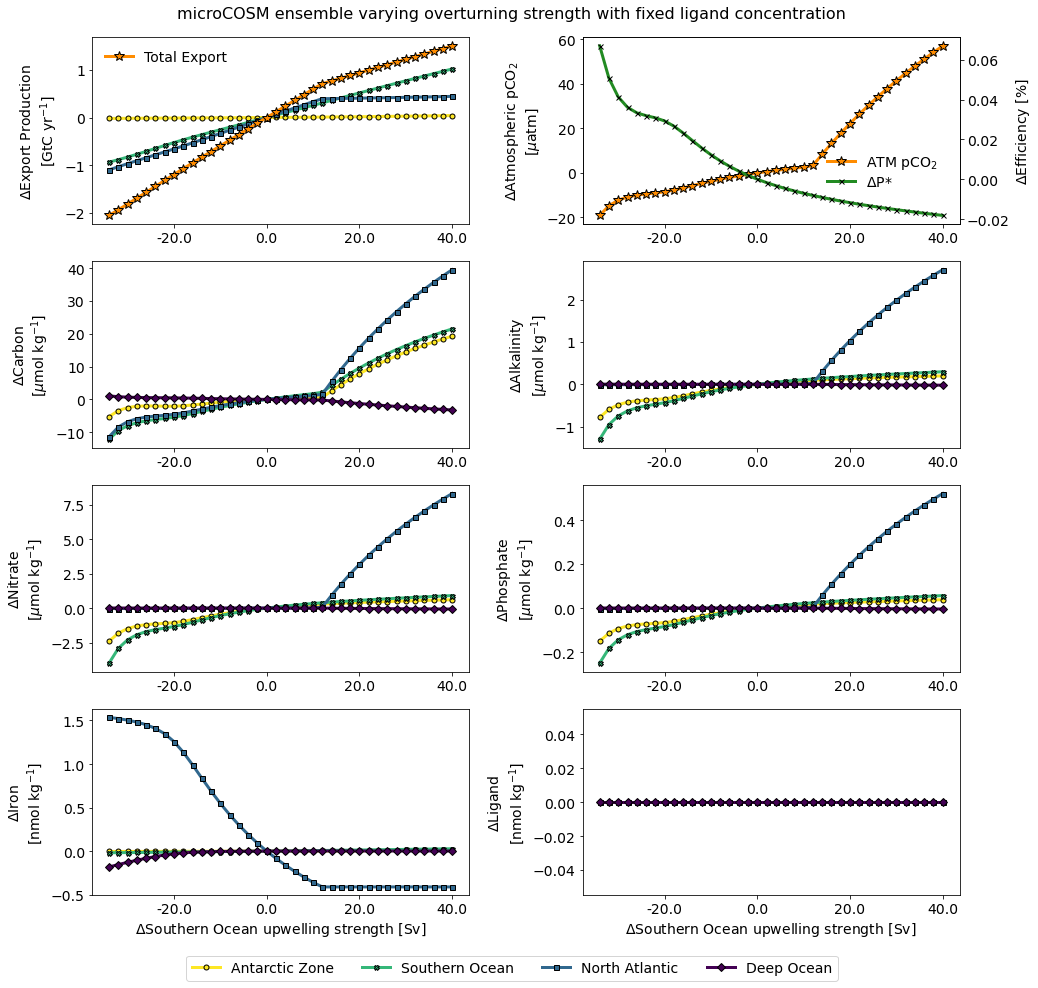

In [116]:
# Plot the timeseries of...
ensemble1_anomaly = ensemble1_output.subtract(
    ensemble1_output.loc[ensemble1_output.psi == 40e6].values
)

len_xaxis, len_yaxis = 4, 4      # fix here your numbers
xspace, yspace       = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig         = len_xaxis / xspace, len_yaxis / yspace

markers = {
    "AA" : ["o", "k", 5],
    "SO" : ["X", "k", 5],
    "NA" : ["s", "k", 5],
    "DO" : ["D", "k", 5],
}

f1, f1ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f1.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

for ii, name in enumerate({n: names[n] for n in ["AA", "SO", "NA"] if n in names}):
    f1ax[0, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["export" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
    )
f1ax[0, 0].plot(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_anomaly["tot_export"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "Total Export",
)
f1ax[0, 0].legend(frameon=False, fontsize=14)
f1ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f1ax[0, 1].plot(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_anomaly["atmpco2"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "ATM pCO$_2$",
)
f1ax[0, 1].legend(
    loc            = "upper left",
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.77, 0.85),
    fontsize       = 14,
    frameon        = False,
)
f1ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f1ax01b = f1ax[0, 1].twinx()
f1ax01b.plot(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_anomaly["pstar"].iloc[3:],
    linewidth       = 3,
    markersize      = 5,
    marker          = "x",
    markeredgecolor = "k",
    color           = "forestgreen",
    label           = "$\Delta$P*",
)
f1ax01b.legend(
    loc="upper left",
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.77, 0.83),
    fontsize       = 14,
    frameon        = False,
)
f1ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

for ii, name in enumerate(names):
    f1ax[1, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["c" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f1ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f1ax[1, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["a" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f1ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f1ax[2, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["n" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f1ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f1ax[2, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["p" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f1ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f1ax[3, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["f" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f1ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f1ax[3, 0].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

for ii, name in enumerate(names):
    f1ax[3, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["l" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f1ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f1ax[3, 1].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with fixed ligand concentration",
    fontsize=16,
)

# Add global box legend at the bottom
f1ax[1, 0].legend(
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.5, 0.055),
    fontsize       = 14,
    ncol           = len(ensemble1_input.iloc[0]["dz"]),
    frameon        = True,
    loc            = "center",
)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.95)
plt.show()

# save the graph
f1.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv.pdf".format(fnadd,psi_max),
    facecolor   = f1.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

Load previous model runs and plot uncertainty ranges

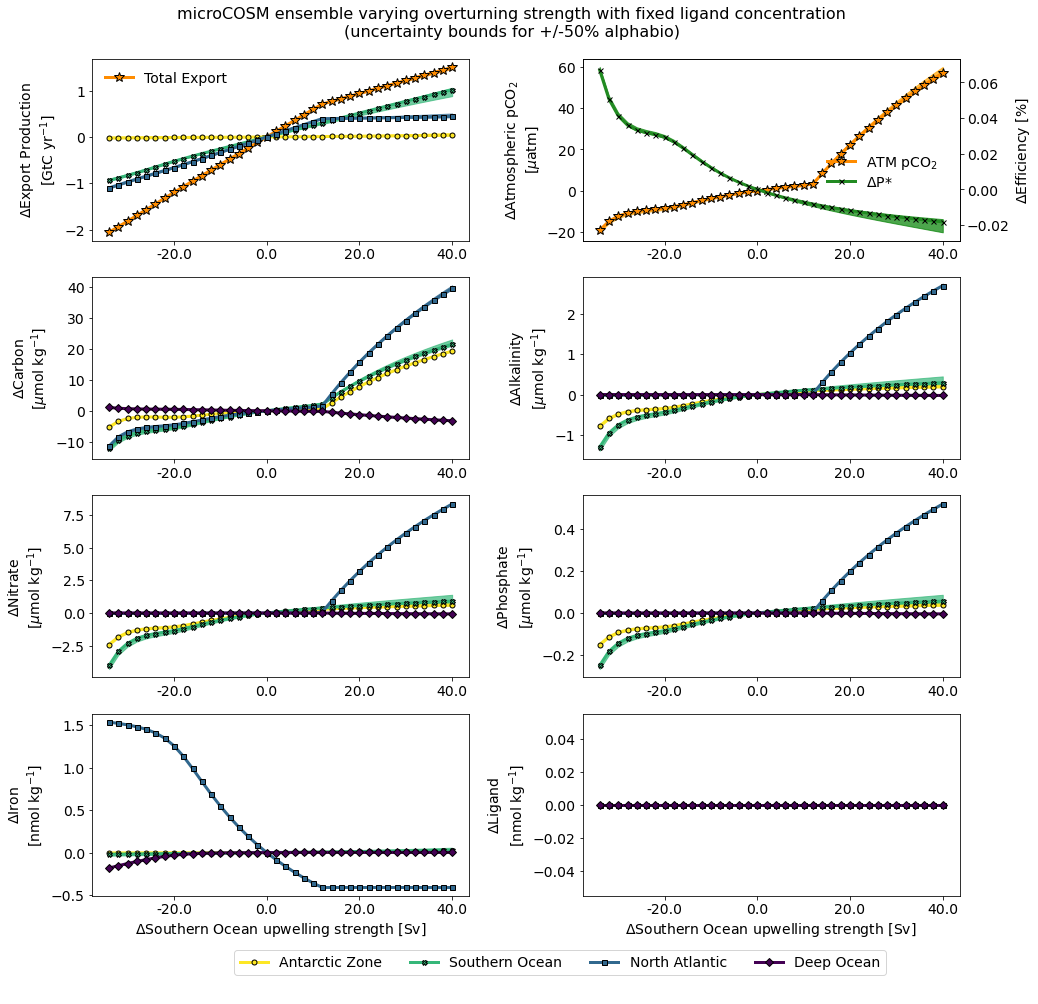

In [117]:
# Load steady state values from before
ensemble1_deca = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"deca"),psi_max)  
)  # .rename(columns={"export1":"exportso","export2":"exportna"})
ensemble1_inca = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"inca"),psi_max)
)  # .rename(columns={"export1":"exportso","export2":"exportna"})


ensemble1_deca_anomaly = ensemble1_deca.subtract(
    ensemble1_deca.loc[ensemble1_deca.psi == 40e6].values
)
ensemble1_inca_anomaly = ensemble1_inca.subtract(
    ensemble1_inca.loc[ensemble1_inca.psi == 40e6].values
)

f2, f2ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f2.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

alpha = 0.7

f2ax[0, 0].plot(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_anomaly["tot_export"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "Total Export",
)
f2ax[0, 0].fill_between(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_deca_anomaly["tot_export"].iloc[3:],
    ensemble1_inca_anomaly["tot_export"].iloc[3:],
    alpha = alpha,
    color = "darkorange",
)
for ii, name in enumerate({n: names[n] for n in ["AA", "SO", "NA"] if n in names}):
    f2ax[0, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["export" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
    )
    f2ax[0, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["export" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["export" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[0, 0].legend(frameon=False, fontsize=14)
f2ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f2ax[0, 1].plot(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_anomaly["atmpco2"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "ATM pCO$_2$",
)
f2ax[0, 1].fill_between(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_deca_anomaly["atmpco2"].iloc[3:],
    ensemble1_inca_anomaly["atmpco2"].iloc[3:],
    alpha = alpha,
    color = "orange",
)
f2ax[0, 1].legend(
    bbox_transform = f2.transFigure,
    bbox_to_anchor = (0.77, 0.85),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f2ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f2ax01b = f2ax[0, 1].twinx()
f2ax01b.plot(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_anomaly["pstar"].iloc[3:],
    linewidth       = 3,
    markersize      = 5,
    marker          = "x",
    markeredgecolor = "k",
    color           = "forestgreen",
    label           = "$\Delta$P*",
)
f2ax01b.fill_between(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_deca_anomaly["pstar"].iloc[3:],
    ensemble1_inca_anomaly["pstar"].iloc[3:],
    alpha = alpha,
    color = "green",
)
f2ax01b.legend(
    bbox_transform = f2.transFigure,
    bbox_to_anchor = (0.77, 0.83),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f2ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[1, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["c" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[1, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["c" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["c" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[1, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["a" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[1, 1].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["a" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["a" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[2, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["n" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[2, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["n" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["n" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[2, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["p" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[2, 1].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["p" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["p" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[3, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["f" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[3, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["f" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["f" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f2ax[3, 0].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[3, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_anomaly["l" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[3, 1].fill_between(
        ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
        ensemble1_deca_anomaly["l" + name.lower()].iloc[3:],
        ensemble1_inca_anomaly["l" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f2ax[3, 1].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
    fontsize=16,
)

# Add global box legend at the bottom
f2ax[1, 0].legend(
    ncol           = len(ensemble1_input.iloc[0]["dz"]),
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.5, 0.04),
    fontsize       = 14,
    frameon        = True,
    loc="center",
)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.93)
plt.show()

# save the graph
f2.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty.pdf".format(fnadd,psi_max),
    facecolor   = f2.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

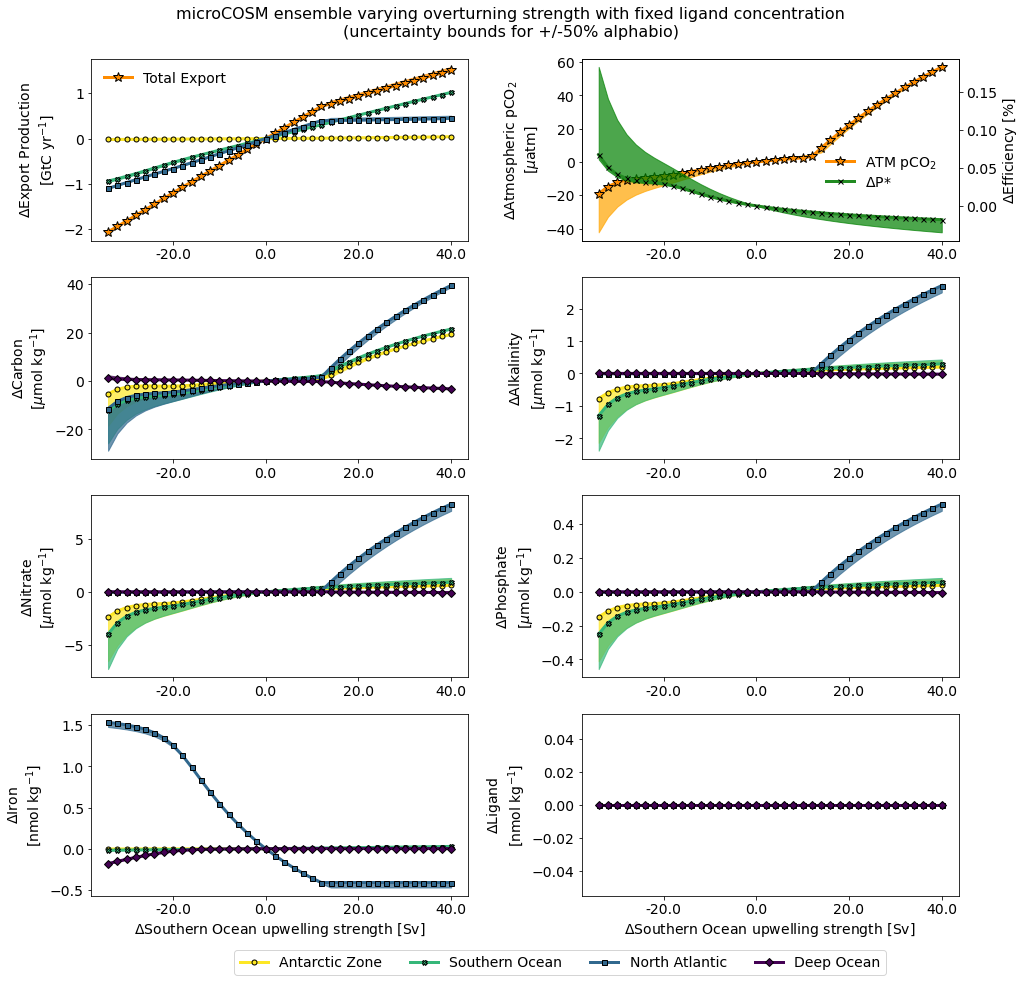

In [120]:
# Load steady state values from before
ensemble1_decd = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"decdust"),psi_max)  
)  # .rename(columns={"export1":"exportso","export2":"exportna"})
ensemble1_incd = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"incdust"),psi_max)
)  # .rename(columns={"export1":"exportso","export2":"exportna"})


ensemble1_decd_anomaly = ensemble1_decd.subtract(
    ensemble1_decd.loc[ensemble1_decd.psi == 40e6].values
)
ensemble1_incd_anomaly = ensemble1_incd.subtract(
    ensemble1_incd.loc[ensemble1_incd.psi == 40e6].values
)

f2, f2ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f2.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

alpha = 0.7

f2ax[0, 0].plot(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_anomaly["tot_export"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "Total Export",
)
f2ax[0, 0].fill_between(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_decd_anomaly["tot_export"].iloc[3:],
    ensemble1_incd_anomaly["tot_export"].iloc[3:],
    alpha = alpha,
    color = "darkorange",
)
for ii, name in enumerate({n: names[n] for n in ["AA", "SO", "NA"] if n in names}):
    f2ax[0, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["export" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
    )
    f2ax[0, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["export" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["export" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[0, 0].legend(frameon=False, fontsize=14)
f2ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f2ax[0, 1].plot(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_anomaly["atmpco2"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "ATM pCO$_2$",
)
f2ax[0, 1].fill_between(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_decd_anomaly["atmpco2"].iloc[3:],
    ensemble1_incd_anomaly["atmpco2"].iloc[3:],
    alpha = alpha,
    color = "orange",
)
f2ax[0, 1].legend(
    bbox_transform = f2.transFigure,
    bbox_to_anchor = (0.77, 0.85),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f2ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f2ax01b = f2ax[0, 1].twinx()
f2ax01b.plot(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_anomaly["pstar"].iloc[3:],
    linewidth       = 3,
    markersize      = 5,
    marker          = "x",
    markeredgecolor = "k",
    color           = "forestgreen",
    label           = "$\Delta$P*",
)
f2ax01b.fill_between(
    ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble1_decd_anomaly["pstar"].iloc[3:],
    ensemble1_incd_anomaly["pstar"].iloc[3:],
    alpha = alpha,
    color = "green",
)
f2ax01b.legend(
    bbox_transform = f2.transFigure,
    bbox_to_anchor = (0.77, 0.83),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f2ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[1, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["c" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[1, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["c" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["c" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[1, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["a" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[1, 1].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["a" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["a" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[2, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["n" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[2, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["n" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["n" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[2, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["p" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[2, 1].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["p" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["p" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[3, 0].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["f" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[3, 0].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["f" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["f" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f2ax[3, 0].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

for ii, name in enumerate(names):
    f2ax[3, 1].plot(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_anomaly["l" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f2ax[3, 1].fill_between(
        ensemble1_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble1_decd_anomaly["l" + name.lower()].iloc[3:],
        ensemble1_incd_anomaly["l" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f2ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f2ax[3, 1].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
    fontsize=16,
)

# Add global box legend at the bottom
f2ax[1, 0].legend(
    ncol           = len(ensemble1_input.iloc[0]["dz"]),
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.5, 0.04),
    fontsize       = 14,
    frameon        = True,
    loc="center",
)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.93)
plt.show()

# save the graph
f2.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty.pdf".format(fnadd,psi_max),
    facecolor   = f2.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

Now, we'll run the same ensemble but with variable ligand concentrations

In [121]:
fadd = "4box"
fnadd = fadd + "variablelt"

load_previous_results=True

if load_previous_results:
    ensemble2_input = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd, psi_max),
    )
else:
    # Load steady state values from before
    model_input = pd.read_json(
        "run_microCOSM_{0}_pickup.json".format(fnadd), typ="series"
    ).to_frame()

    # repeat the input parameters and adjust for the ensemble run
    ensemble2_input = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)

    ensemble2_input["nyrs"]  = 1e4
    ensemble2_input["tout"]  = 10
    ensemble2_input["psi"]   = psi_var
    ensemble2_input["niter"] = niter

    ensemble2_input.to_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd, psi_max),
    )
ensemble2_input.iloc[0]

niter                                                         0
nyrs                                                      10000
tout                                                         10
nout                                                       1001
dx             [17000000.0, 17000000.0, 17000000.0, 17000000.0]
dy               [1000000.0, 3000000.0, 12000000.0, 16000000.0]
dz                                   [50.0, 50.0, 50.0, 5050.0]
depth                                [25.0, 25.0, 25.0, 2575.0]
latitude                          [-84.375, -61.875, 22.5, 0.0]
Kmix          [[0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0], [...
Rremin        [[-1.0, 0.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0],...
Pcir          [[0.0, 0.5, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...
psi                                                           0
dif                                                     1000000
alphabio                                               0.000006
gamma                                   

Run the experiment

In [122]:
if load_previous_results:
    print(
        "Loading output from: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )
    )
    ensemble2_output = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max),
    )
else:
    start = time.time()
    if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
        # Run in parallel using pkg/pandarallel's "parallel_apply"
        import multiprocessing
    
        ensemble2_output = run_microcosm(
            ensemble2_input, workers=multiprocessing.cpu_count()
        )
    else:  # about 3 mins in serial
        # OR in series using pandas' "apply" to run through rows of a data frame of inputs
        ensemble2_output = run_microcosm(ensemble2_input, workers=1)
    end = time.time()
    print("{0} seconds".format((end - start)))

# save the output
    print(
        "Saving output to: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )
    )
    ensemble2_output.to_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max)
    )

Loading output from: run_microCOSM_4boxvariablelt_psi_80Sv_output.json


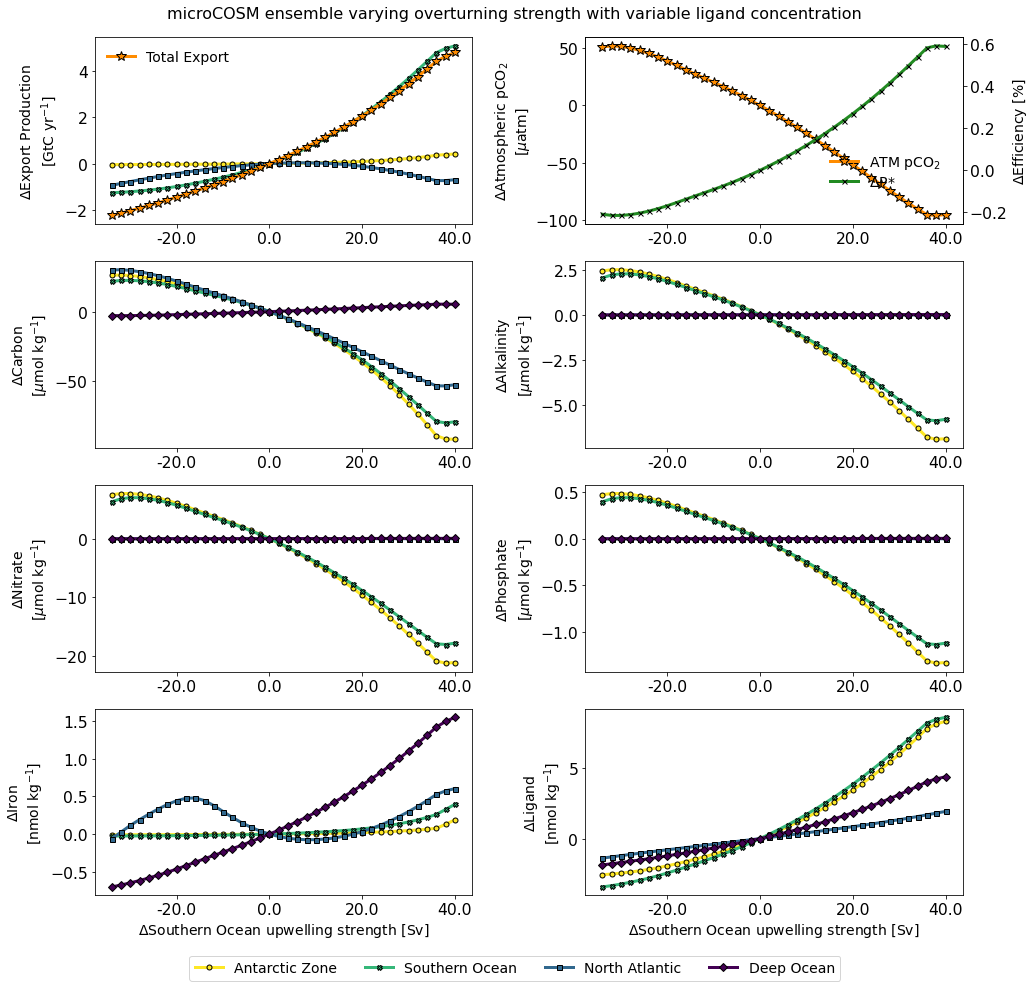

In [131]:
# Plot the timeseries of...
ensemble2_anomaly = ensemble2_output.subtract(
    ensemble2_output.loc[ensemble2_output.psi == 40e6].values
)

len_xaxis, len_yaxis = 4, 4      # fix here your numbers
xspace, yspace       = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig         = len_xaxis / xspace, len_yaxis / yspace

markers = {
    "AA" : ["o", "k", 5],
    "SO" : ["X", "k", 5],
    "NA" : ["s", "k", 5],
    "DO" : ["D", "k", 5],
}

f3, f3ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f3.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

for ii, name in enumerate({n: names[n] for n in ["AA", "SO", "NA"] if n in names}):
    f3ax[0, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["export" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
    )
f3ax[0, 0].plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["tot_export"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "Total Export",
)
f3ax[0, 0].legend(frameon=False, fontsize=14)
f3ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f3ax[0, 1].plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["atmpco2"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "ATM pCO$_2$",
)
f3ax[0, 1].legend(
    loc            = "upper left",
    bbox_transform = f3.transFigure,
    bbox_to_anchor = (0.77, 0.85),
    fontsize       = 14,
    frameon        = False,
)
f3ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f3ax01b = f3ax[0, 1].twinx()
f3ax01b.plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["pstar"].iloc[3:],
    linewidth       = 3,
    markersize      = 5,
    marker          = "x",
    markeredgecolor = "k",
    color           = "forestgreen",
    label           = "$\Delta$P*",
)
f3ax01b.legend(
    loc="upper left",
    bbox_transform = f3.transFigure,
    bbox_to_anchor = (0.77, 0.83),
    fontsize       = 14,
    frameon        = False,
)
f3ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

for ii, name in enumerate(names):
    f3ax[1, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["c" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f3ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f3ax[1, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["a" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f3ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f3ax[2, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["n" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f3ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f3ax[2, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["p" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f3ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f3ax[3, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["f" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f3ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f3ax[3, 0].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

for ii, name in enumerate(names):
    f3ax[3, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["l" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
f3ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f3ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f3ax[3, 1].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with variable ligand concentration",
    fontsize=16,
)

# Add global box legend at the bottom
f3ax[1, 0].legend(
    bbox_transform = f3.transFigure,
    bbox_to_anchor = (0.5, 0.055),
    fontsize       = 14,
    ncol           = len(ensemble2_input.iloc[0]["dz"]),
    frameon        = True,
    loc            = "center",
)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.95)
plt.show()

# save the graph
f3.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv.pdf".format(fnadd,psi_max),
    facecolor   = f3.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

Load previous model runs and plot uncertainty

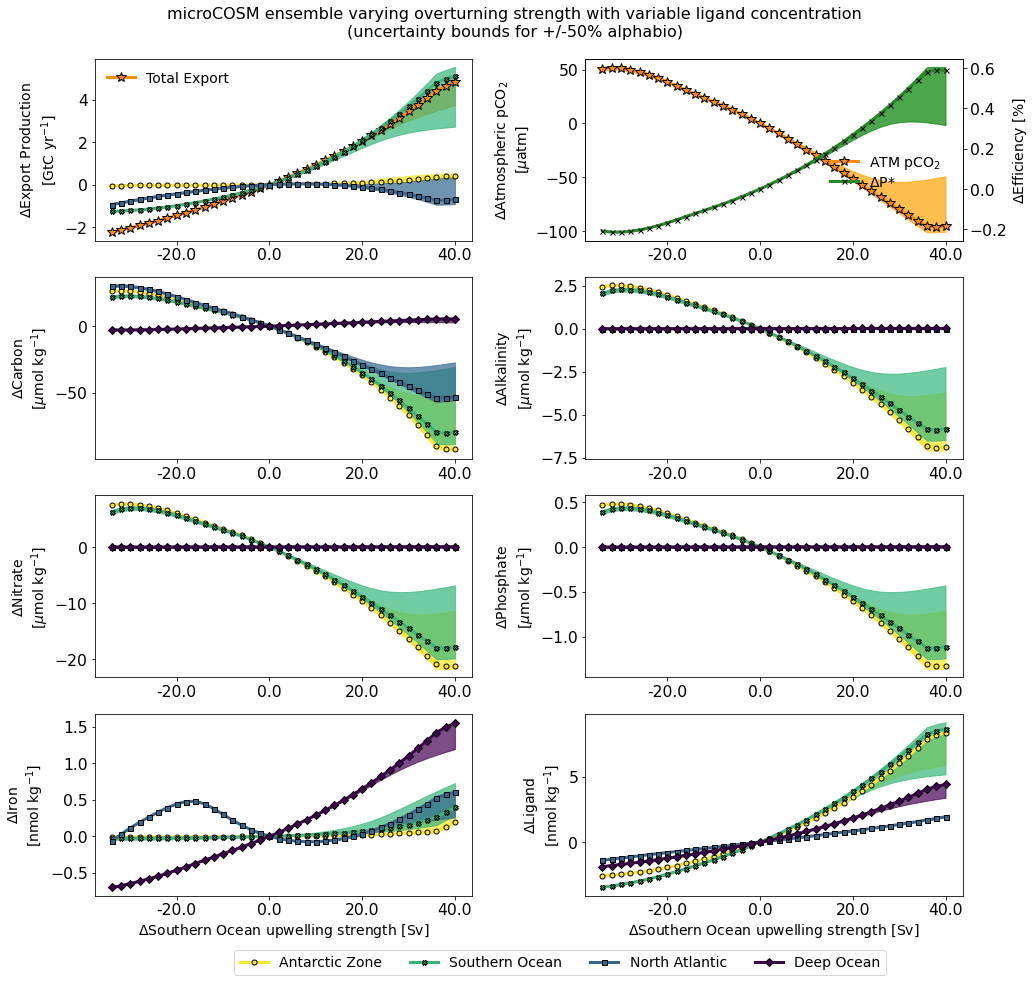

In [132]:
# Load steady state values from before
ensemble2_deca = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"deca"),psi_max)  
)  # .rename(columns={"export1":"exportso","export2":"exportna"})
ensemble2_inca = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"inca"),psi_max)
)  # .rename(columns={"export1":"exportso","export2":"exportna"})


ensemble2_deca_anomaly = ensemble2_deca.subtract(
    ensemble2_deca.loc[ensemble2_deca.psi == 40e6].values
)
ensemble2_inca_anomaly = ensemble2_inca.subtract(
    ensemble2_inca.loc[ensemble2_inca.psi == 40e6].values
)

f4, f4ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f4.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

alpha = 0.7

f4ax[0, 0].plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["tot_export"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "Total Export",
)
f4ax[0, 0].fill_between(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_deca_anomaly["tot_export"].iloc[3:],
    ensemble2_inca_anomaly["tot_export"].iloc[3:],
    alpha = alpha,
    color = "darkorange",
)
for ii, name in enumerate({n: names[n] for n in ["AA", "SO", "NA"] if n in names}):
    f4ax[0, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["export" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
    )
    f4ax[0, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["export" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["export" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[0, 0].legend(frameon=False, fontsize=14)
f4ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f4ax[0, 1].plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["atmpco2"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "ATM pCO$_2$",
)
f4ax[0, 1].fill_between(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_deca_anomaly["atmpco2"].iloc[3:],
    ensemble2_inca_anomaly["atmpco2"].iloc[3:],
    alpha = alpha,
    color = "orange",
)
f4ax[0, 1].legend(
    bbox_transform = f4.transFigure,
    bbox_to_anchor = (0.77, 0.85),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f4ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f4ax01b = f4ax[0, 1].twinx()
f4ax01b.plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["pstar"].iloc[3:],
    linewidth       = 3,
    markersize      = 5,
    marker          = "x",
    markeredgecolor = "k",
    color           = "forestgreen",
    label           = "$\Delta$P*",
)
f4ax01b.fill_between(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_deca_anomaly["pstar"].iloc[3:],
    ensemble2_inca_anomaly["pstar"].iloc[3:],
    alpha = alpha,
    color = "green",
)
f4ax01b.legend(
    bbox_transform = f4.transFigure,
    bbox_to_anchor = (0.77, 0.83),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f4ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[1, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["c" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[1, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["c" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["c" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[1, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["a" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[1, 1].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["a" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["a" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[2, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["n" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[2, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["n" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["n" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[2, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["p" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[2, 1].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["p" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["p" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[3, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["f" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[3, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["f" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["f" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f4ax[3, 0].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[3, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["l" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[3, 1].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_deca_anomaly["l" + name.lower()].iloc[3:],
        ensemble2_inca_anomaly["l" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f4ax[3, 1].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
    fontsize=16,
)

# Add global box legend at the bottom
f4ax[1, 0].legend(
    ncol           = len(ensemble2_input.iloc[0]["dz"]),
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.5, 0.04),
    fontsize       = 14,
    frameon        = True,
    loc="center",
)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.93)
plt.show()

# save the graph
f4.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty.pdf".format(fnadd,psi_max),
    facecolor   = f4.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

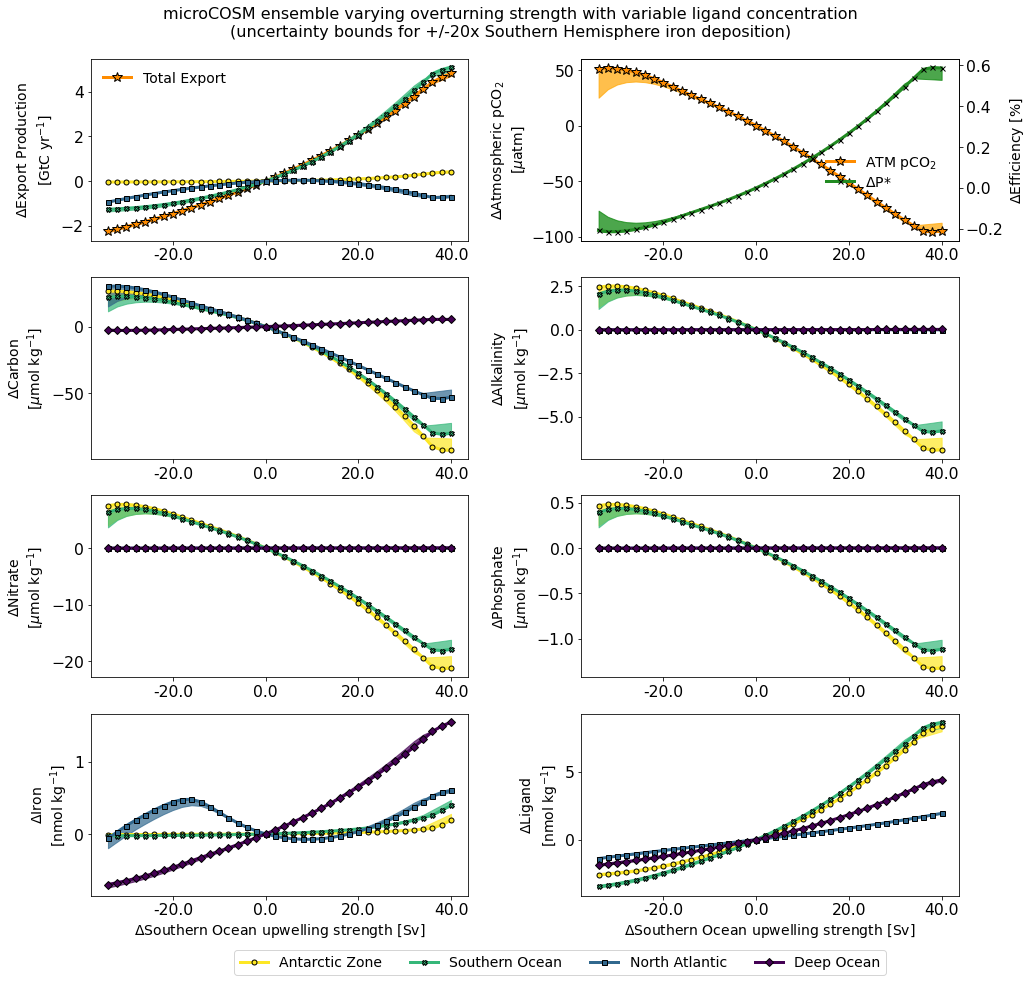

In [133]:
# Load steady state values from before
ensemble2_decd = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"decdust"),psi_max)  
)  # .rename(columns={"export1":"exportso","export2":"exportna"})
ensemble2_incd = pd.read_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd.replace(fadd,fadd+"incdust"),psi_max)
)  # .rename(columns={"export1":"exportso","export2":"exportna"})


ensemble2_decd_anomaly = ensemble2_decd.subtract(
    ensemble2_decd.loc[ensemble2_decd.psi == 40e6].values
)
ensemble2_incd_anomaly = ensemble2_incd.subtract(
    ensemble2_incd.loc[ensemble2_incd.psi == 40e6].values
)

f4, f4ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f4.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

alpha = 0.7

f4ax[0, 0].plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["tot_export"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "Total Export",
)
f4ax[0, 0].fill_between(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_decd_anomaly["tot_export"].iloc[3:],
    ensemble2_incd_anomaly["tot_export"].iloc[3:],
    alpha = alpha,
    color = "darkorange",
)
for ii, name in enumerate({n: names[n] for n in ["AA", "SO", "NA"] if n in names}):
    f4ax[0, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["export" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
    )
    f4ax[0, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["export" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["export" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[0, 0].legend(frameon=False, fontsize=14)
f4ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f4ax[0, 1].plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["atmpco2"].iloc[3:],
    linewidth       = 3,
    markersize      = 10,
    marker          = "*",
    markeredgecolor = "k",
    color           = "darkorange",
    label           = "ATM pCO$_2$",
)
f4ax[0, 1].fill_between(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_decd_anomaly["atmpco2"].iloc[3:],
    ensemble2_incd_anomaly["atmpco2"].iloc[3:],
    alpha = alpha,
    color = "orange",
)
f4ax[0, 1].legend(
    bbox_transform = f4.transFigure,
    bbox_to_anchor = (0.77, 0.85),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f4ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f4ax01b = f4ax[0, 1].twinx()
f4ax01b.plot(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_anomaly["pstar"].iloc[3:],
    linewidth       = 3,
    markersize      = 5,
    marker          = "x",
    markeredgecolor = "k",
    color           = "forestgreen",
    label           = "$\Delta$P*",
)
f4ax01b.fill_between(
    ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
    ensemble2_decd_anomaly["pstar"].iloc[3:],
    ensemble2_incd_anomaly["pstar"].iloc[3:],
    alpha = alpha,
    color = "green",
)
f4ax01b.legend(
    bbox_transform = f4.transFigure,
    bbox_to_anchor = (0.77, 0.83),
    fontsize       = 14,
    frameon        = False,
    loc            = "upper left",
)
f4ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[1, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["c" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[1, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["c" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["c" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[1, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["a" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[1, 1].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["a" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["a" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[2, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["n" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[2, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["n" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["n" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[2, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["p" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[2, 1].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["p" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["p" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[3, 0].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["f" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[3, 0].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["f" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["f" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f4ax[3, 0].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

for ii, name in enumerate(names):
    f4ax[3, 1].plot(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_anomaly["l" + name.lower()].iloc[3:],
        linewidth       = 3,
        marker          = markers[name][0],
        markeredgecolor = markers[name][1],
        markersize      = markers[name][2],
        color           = mycm(ii / (len(names) - 1)),
        label           = names[name],
    )
    f4ax[3, 1].fill_between(
        ensemble2_anomaly["psi"].iloc[3:]* 1e-6,
        ensemble2_decd_anomaly["l" + name.lower()].iloc[3:],
        ensemble2_incd_anomaly["l" + name.lower()].iloc[3:],
        alpha = alpha,
        color = mycm(ii / (len(names) - 1)),
    )
f4ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f4ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f4ax[3, 1].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for +/-20x Southern Hemisphere iron deposition)",
    fontsize=16,
)

# Add global box legend at the bottom
f4ax[1, 0].legend(
    ncol           = len(ensemble2_input.iloc[0]["dz"]),
    bbox_transform = f1.transFigure,
    bbox_to_anchor = (0.5, 0.04),
    fontsize       = 14,
    frameon        = True,
    loc="center",
)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.93)
plt.show()

# save the graph
f4.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty.pdf".format(fnadd,psi_max),
    facecolor   = f4.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

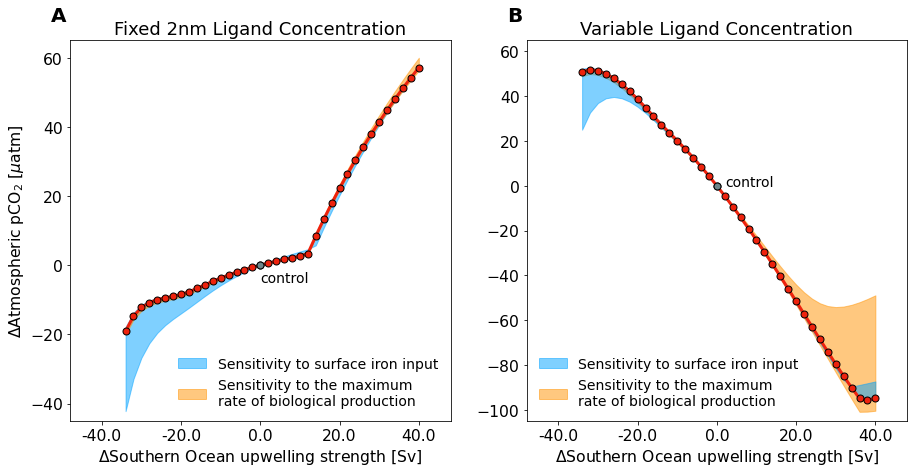

In [134]:
plt.rcParams['xtick.labelsize'] ='large'
plt.rcParams['ytick.labelsize'] ='large'
plt.rcParams['axes.labelsize' ] ='large'
plt.rcParams['legend.fontsize'] ='14'
plt.rcParams['figure.titlesize']='large'
plt.rcParams['font.size']       ='13'

colors=['#305cd0','#00a2ff','#6d868a','#fae430','#ff9300','#ee220d']
cmap = mp.colors.LinearSegmentedColormap.from_list('Zissou',[mp.colors.hex2color(x) for x in colors], N=6)

model_output  = [ensemble1_output,  ensemble2_output ]
model_anomaly = [ensemble1_anomaly, ensemble2_anomaly]

[ s_pco2mocflig, 
  i_pco2mocflig, 
  r_pco2mocflig, 
  p_pco2mocflig, 
  se_pco2mocflig ] = st.linregress(
    ensemble1_anomaly["psi"    ].iloc[3:] * 1e-6,
    ensemble1_anomaly["atmpco2"].iloc[3:]
)

[ s_pco2mocvlig, 
  i_pco2mocvlig, 
  r_pco2mocvlig, 
  p_pco2mocvlig, 
  se_pco2mocvlig ] = st.linregress(
    ensemble2_anomaly["psi"    ].iloc[3:] * 1e-6,
    ensemble2_anomaly["atmpco2"].iloc[3:]
)


f5, f5ax = plt.subplots(figsize=(15, 7), ncols=2, nrows=1)
f5.patch.set_facecolor("None")
f5cb = f5ax.copy()

plotargs = {
        'linewidth'       : 3,
        'markersize'      : 7,
        'marker'          : "o",
        'markeredgecolor' : "k",
}

for mm in np.arange(len(model_output)):
    f5ax[mm].plot(
        model_anomaly[mm]["psi"    ].iloc[3:] * 1e-6,
        model_anomaly[mm]["atmpco2"].iloc[3:],
        color           = cmap(6),
        label           = "ATM pCO$_2$",
        **plotargs,
    )
        
    f5ax[mm].plot(
        model_anomaly[mm]["psi"    ].loc[model_output[mm]["psi"] == 40e6] * 1e-6,
        model_anomaly[mm]["atmpco2"].loc[model_output[mm]["psi"] == 40e6],
        color           = cmap(2),
        **plotargs,
    )
    
    if mm == 0:
        ylim       = (-45, 65)    
        title_text = "Fixed 2nm Ligand Concentration"
        cntrl_x    =  0.0
        cntrl_y    = -5.0
    else:
        ylim       = (-105, 65)
        title_text = "Variable Ligand Concentration"
        cntrl_x    = 2.0
        cntrl_y    = 0.0
        
    f5ax[mm].text(
        cntrl_x, 
        cntrl_y,
        "control",
        fontsize            = 14,
        horizontalalignment = "left",
        )
    
    f5ax[mm].set(xlim=(-48, 48), ylim=ylim)
    f5ax[mm].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    f5ax[mm].set_xlabel("$\Delta$Southern Ocean upwelling strength [Sv]")
    f5ax[mm].set_title(title_text, fontsize=18)
    if mm==0:
        f5ax[mm].set_ylabel("$\Delta$Atmospheric pCO$_2$ [$\mu$atm]")

# Draw on the sensitivity envelopes for dust and alpha bio
dusthdl = f5ax[0].fill_between(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_decd_anomaly["atmpco2"].iloc[3:],
    ensemble1_incd_anomaly["atmpco2"].iloc[3:],
    color = cmap(1),
    alpha = 0.5,
)

biophdl = f5ax[0].fill_between(
    ensemble1_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble1_deca_anomaly["atmpco2"].iloc[3:],
    ensemble1_inca_anomaly["atmpco2"].iloc[3:],
    color = cmap(4),
    alpha = 0.5,
)

f5ax[0].legend([dusthdl,biophdl], 
               ["Sensitivity to surface iron input", 
                "Sensitivity to the maximum\nrate of biological production"], 
               loc     = "lower right",
               frameon = False,
)

dusthdl = f5ax[1].fill_between(
    ensemble2_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble2_decd_anomaly["atmpco2"].iloc[3:],
    ensemble2_incd_anomaly["atmpco2"].iloc[3:],
    color = cmap(1),
    alpha = 0.5,
)

biophdl = f5ax[1].fill_between(
    ensemble2_anomaly["psi"].iloc[3:] * 1e-6,
    ensemble2_deca_anomaly["atmpco2"].iloc[3:],
    ensemble2_inca_anomaly["atmpco2"].iloc[3:],
    color = cmap(4),
    alpha = 0.5,
    zorder=-1,
)

f5ax[1].legend([dusthdl,biophdl], 
               ["Sensitivity to surface iron input", 
                "Sensitivity to the maximum\nrate of biological production"], 
               loc     = "lower left",
               frameon = False,
)

label_axes(f5ax)
plt.show()
f5.savefig(
    "microCOSM_ensemble_psi_pco2_anomaly.pdf",
    facecolor   = f5.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)

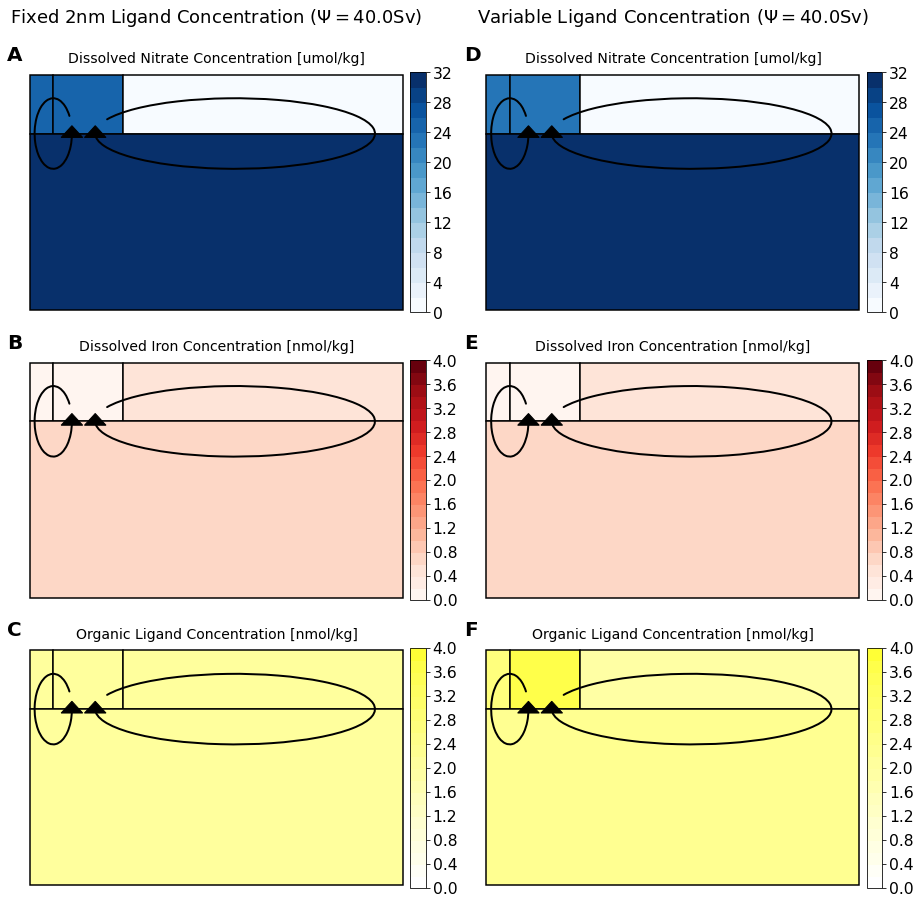

In [135]:
tstep = ensemble1_output.index[ensemble1_output["psi"] == 40e6][0]

# Create a Rectangle patch
patches = {
    "AA" : {
        "x"  : 0.00,
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "SO" : {
        "x"  : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][1] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "NA" : {
        "x" : (ensemble1_input["dy"].iloc[0][0] + ensemble1_input["dy"].iloc[0][1])
             / ensemble1_input["dy"].iloc[0][3],
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][2] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "DO" : {
        "x"  : 0.0,
        "y"  : 0.0,
        "dx" : ensemble1_input["dy"].iloc[0][3] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.75,
    },
    "AMOC" : {
        "x"     : 0.55,
        "y"     : 0.75,
        "dx"    : 0.75,
        "dy"    : 0.3,
        "angle" : 0,
        "start" : 180,
        "end"   : 170,
    },
    "AABW" : {
        "x"     : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "y"     : 0.75,
        "dx" : 0.1,
        "dy" : 0.3,
        "angle" : 0,
        "start" : 60,
        "end"   : 360,
    },
}

plot_vars = {
    "n" : {
        "max"    : 32,
        "min"    : 0,
        "bounds" : np.arange(0, 34, 2),
        "cmap"   : plt.cm.get_cmap("Blues").copy(),
        "title"  : "Dissolved Nitrate Concentration [umol/kg]",   
        },
    "f": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : plt.cm.get_cmap("Reds").copy(),
        "title"  : "Dissolved Iron Concentration [nmol/kg]",
    },
    "l": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : mp.colors.ListedColormap( 
                        mp.cm.get_cmap("hot_r")( 
                            np.linspace( 
                                0.0, 0.2, len(np.arange(0, 4.2, 0.2))
                            ),
                        )),      
        "title"  : "Organic Ligand Concentration [nmol/kg]",
    },
}

boxargs = {
         "linewidth" : 1.5,
         "edgecolor" : "black",
        }

arcargs = {
         "capstyle"  : 'round',
         "linestyle" : '-',
         "linewidth" : 2,
         "color"     : "black",
        }

model_output  = [ensemble1_output,  ensemble2_output ]
model_anomaly = [ensemble1_anomaly, ensemble2_anomaly]

f7, f7ax = plt.subplots(figsize=(15, 15), ncols=2, nrows=3)
f7.patch.set_facecolor("None")
f7ca = f7ax.copy()
f7cb = f7ax.copy()

for mm in np.arange(len(model_output)):
    for ii, chem in enumerate(plot_vars.keys()):
        f7ax[ii, mm].axes.get_xaxis().set_visible(False)
        f7ax[ii, mm].get_yaxis().set_visible(False)
        f7ax[ii, mm].set_facecolor((1, 1, 1, 0))
        f7ax[ii, mm].set_axis_off()

        norm = mp.colors.BoundaryNorm(
            plot_vars[chem]["bounds"],
            plot_vars[chem]["cmap"].N,
        )
        mycmp = plt.cm.ScalarMappable(
            norm=norm,
            cmap=plot_vars[chem]["cmap"],
        )

        aapatch = Rectangle(
                (patches["AA"]["x"], patches["AA"]["y"]),
                patches["AA"]["dx"],
                patches["AA"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "aa"]),
                **boxargs,
        )
        sopatch = Rectangle(
                (patches["SO"]["x"], patches["SO"]["y"]),
                patches["SO"]["dx"],
                patches["SO"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "so"]),
                **boxargs,
        )
        napatch = Rectangle(
                (patches["NA"]["x"], patches["NA"]["y"]),
                patches["NA"]["dx"],
                patches["NA"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "na"]),
                **boxargs,
        )
        dopatch = Rectangle(
                (patches["DO"]["x"], patches["DO"]["y"]),
                patches["DO"]["dx"],
                patches["DO"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "do"]),
                **boxargs,
        )     

        amocarc = Arc(
                [patches["AMOC"]["x"], patches["AMOC"]["y"]],
                patches["AMOC"]["dx"],
                patches["AMOC"]["dy"],
                angle  = patches["AMOC"]["angle"],
                theta1 = patches["AMOC"]["start"],
                theta2 = patches["AMOC"]["end"],
                **arcargs,
        )

        aabwarc = Arc(
                [patches["AABW"]["x"], patches["AABW"]["y"]],
                patches["AABW"]["dx"],
                patches["AABW"]["dy"],
                angle  = patches["AABW"]["angle"],
                theta1 = patches["AABW"]["start"],
                theta2 = patches["AABW"]["end"],
                **arcargs,
        )
        
        amocarrow = RegularPolygon(
                (
                 patches["AMOC"]["x"]+(patches["AMOC"]["dx"]/2)*
                    np.cos(np.radians(patches["AMOC"]["start"]+patches["AMOC"]["angle"])), 
                 patches["AMOC"]["y"]+(patches["AMOC"]["dy"]/2)*
                    np.sin(np.radians(patches["AMOC"]["start"]+patches["AMOC"]["angle"]))
                ),           
                orientation = np.radians(patches["AMOC"]["angle"]+patches["AMOC"]["start"]+180),     
                radius      = patches["AMOC"]["dy"]/9,
                numVertices = 3,
                color       = arcargs["color"]
        )
        
        aabwarrow = RegularPolygon(
                (
                 patches["AABW"]["x"]+(patches["AABW"]["dx"]/2)*
                    np.cos(np.radians(patches["AABW"]["end"]+patches["AABW"]["angle"])), 
                 patches["AABW"]["y"]+(patches["AABW"]["dy"]/2)*
                    np.sin(np.radians(patches["AABW"]["end"]+patches["AABW"]["angle"]))
                ),           
                orientation = np.radians(patches["AABW"]["angle"]+patches["AABW"]["end"]),     
                radius      = patches["AABW"]["dy"]/9,
                numVertices = 3,
                color       = arcargs["color"]
        )
            
        for patch in [aapatch, sopatch, napatch, dopatch, amocarc, amocarrow, aabwarc, aabwarrow]:
            f7ax[ii, mm].add_patch(patch)

        f7ax[ii, mm].set(
            xlim = (-0.01, 1.01),
            ylim = (-0.01, 1.01),
        )
        
        if ii==0 and mm == 0:
            title_text = "Fixed 2nm Ligand Concentration ($\Psi=${0}Sv)\n\n" \
                .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
            f7ax[ii,mm].set_title(title_text, fontsize=18)
        elif ii==0 and mm==1:
            title_text = "Variable Ligand Concentration ($\Psi=${0}Sv)\n\n" \
                .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
            f7ax[ii,mm].set_title(title_text, fontsize=18)

        f7ax[ii, mm].text(
            0.5,
            1.05,
            plot_vars[chem]["title"],
            fontsize            = 14,
            horizontalalignment = "center",
        )

        # Add a colorbar to the model sections
        f7ca[ii, mm] = inset_axes(
            f7ax[ii, mm],
            width          = "4%",
            height         = "100%",
            bbox_to_anchor = (0.05, 0, 1, 1),
            bbox_transform = f7ax[ii, mm].transAxes,
            borderpad      = 0,
        )
        
        f7cb[ii, mm] = f7.colorbar(
            mycmp,
            cax         = f7ca[ii, mm],
            orientation = "vertical",
            ticks       = plot_vars[chem]["bounds"][::2],
        )
        
        f7cb[ii, mm].solids.set_edgecolor("face")
        
label_axes(f7ax,label_columns=True)
plt.show()
# save the graph
f7.savefig(
    "microCOSM_ensemble_psi_{0:.0f}Sv_sections.pdf".format(model_output[mm]["psi"].iloc[tstep]*1e-6),
    facecolor   = f7.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)

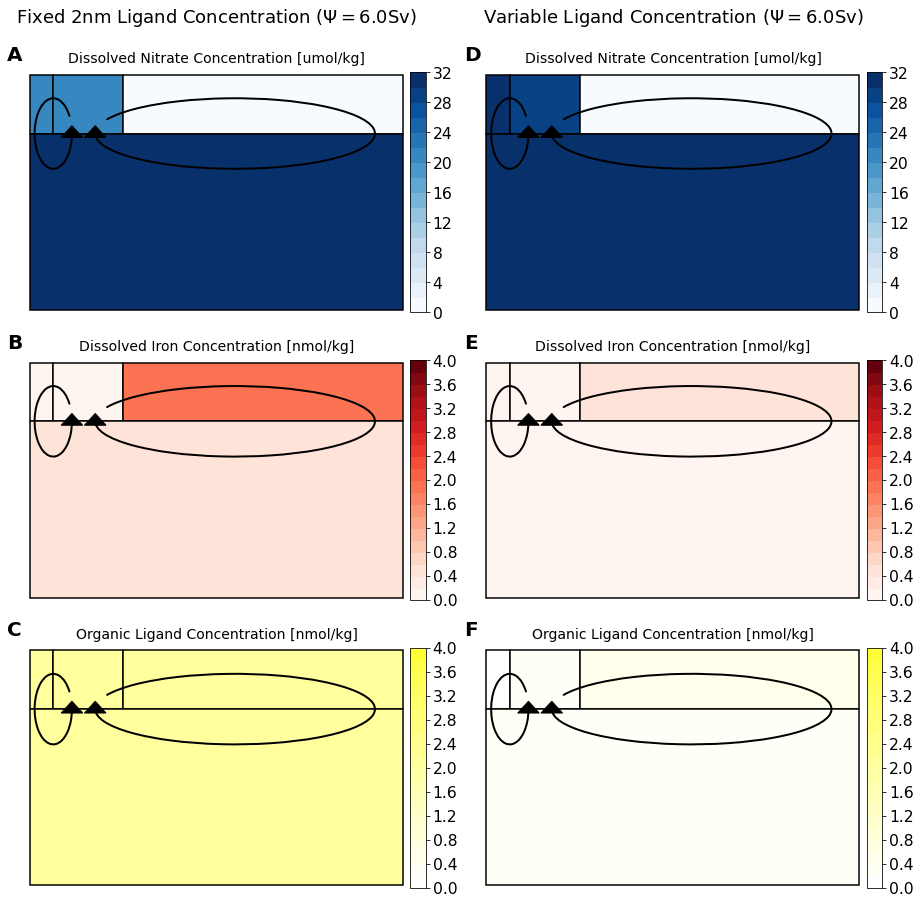

In [136]:
tstep = 3

# Create a Rectangle patch
patches = {
    "AA" : {
        "x"  : 0.00,
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "SO" : {
        "x"  : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][1] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "NA" : {
        "x" : (ensemble1_input["dy"].iloc[0][0] + ensemble1_input["dy"].iloc[0][1])
             / ensemble1_input["dy"].iloc[0][3],
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][2] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "DO" : {
        "x"  : 0.0,
        "y"  : 0.0,
        "dx" : ensemble1_input["dy"].iloc[0][3] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.75,
    },
    "AMOC" : {
        "x"     : 0.55,
        "y"     : 0.75,
        "dx"    : 0.75,
        "dy"    : 0.3,
        "angle" : 0,
        "start" : 180,
        "end"   : 170,
    },
    "AABW" : {
        "x"     : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "y"     : 0.75,
        "dx" : 0.1,
        "dy" : 0.3,
        "angle" : 0,
        "start" : 60,
        "end"   : 360,
    },
}

plot_vars = {
    "n" : {
        "max"    : 32,
        "min"    : 0,
        "bounds" : np.arange(0, 34, 2),
        "cmap"   : plt.cm.get_cmap("Blues").copy(),
        "title"  : "Dissolved Nitrate Concentration [umol/kg]",   
        },
    "f": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : plt.cm.get_cmap("Reds").copy(),
        "title"  : "Dissolved Iron Concentration [nmol/kg]",
    },
    "l": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : mp.colors.ListedColormap( 
                        mp.cm.get_cmap("hot_r")( 
                            np.linspace( 
                                0.0, 0.2, len(np.arange(0, 4.2, 0.2))
                            ),
                        )),      
        "title"  : "Organic Ligand Concentration [nmol/kg]",
    },
}

boxargs = {
         "linewidth" : 1.5,
         "edgecolor" : "black",
        }

arcargs = {
         "capstyle"  : 'round',
         "linestyle" : '-',
         "linewidth" : 2,
         "color"     : "black",
        }

model_output  = [ensemble1_output,  ensemble2_output ]
model_anomaly = [ensemble1_anomaly, ensemble2_anomaly]

f8, f8ax = plt.subplots(figsize=(15, 15), ncols=2, nrows=3)
f8.patch.set_facecolor("None")
f8ca = f8ax.copy()
f8cb = f8ax.copy()

for mm in np.arange(len(model_output)):
    for ii, chem in enumerate(plot_vars.keys()):
        f8ax[ii, mm].axes.get_xaxis().set_visible(False)
        f8ax[ii, mm].get_yaxis().set_visible(False)
        f8ax[ii, mm].set_facecolor((1, 1, 1, 0))
        f8ax[ii, mm].set_axis_off()

        norm = mp.colors.BoundaryNorm(
            plot_vars[chem]["bounds"],
            plot_vars[chem]["cmap"].N,
        )
        mycmp = plt.cm.ScalarMappable(
            norm=norm,
            cmap=plot_vars[chem]["cmap"],
        )

        aapatch = Rectangle(
                (patches["AA"]["x"], patches["AA"]["y"]),
                patches["AA"]["dx"],
                patches["AA"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "aa"]),
                **boxargs,
        )
        sopatch = Rectangle(
                (patches["SO"]["x"], patches["SO"]["y"]),
                patches["SO"]["dx"],
                patches["SO"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "so"]),
                **boxargs,
        )
        napatch = Rectangle(
                (patches["NA"]["x"], patches["NA"]["y"]),
                patches["NA"]["dx"],
                patches["NA"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "na"]),
                **boxargs,
        )
        dopatch = Rectangle(
                (patches["DO"]["x"], patches["DO"]["y"]),
                patches["DO"]["dx"],
                patches["DO"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "do"]),
                **boxargs,
        )     

        amocarc = Arc(
                [patches["AMOC"]["x"], patches["AMOC"]["y"]],
                patches["AMOC"]["dx"],
                patches["AMOC"]["dy"],
                angle  = patches["AMOC"]["angle"],
                theta1 = patches["AMOC"]["start"],
                theta2 = patches["AMOC"]["end"],
                **arcargs,
        )

        aabwarc = Arc(
                [patches["AABW"]["x"], patches["AABW"]["y"]],
                patches["AABW"]["dx"],
                patches["AABW"]["dy"],
                angle  = patches["AABW"]["angle"],
                theta1 = patches["AABW"]["start"],
                theta2 = patches["AABW"]["end"],
                **arcargs,
        )
        
        amocarrow = RegularPolygon(
                (
                 patches["AMOC"]["x"]+(patches["AMOC"]["dx"]/2)*
                    np.cos(np.radians(patches["AMOC"]["start"]+patches["AMOC"]["angle"])), 
                 patches["AMOC"]["y"]+(patches["AMOC"]["dy"]/2)*
                    np.sin(np.radians(patches["AMOC"]["start"]+patches["AMOC"]["angle"]))
                ),           
                orientation = np.radians(patches["AMOC"]["angle"]+patches["AMOC"]["start"]+180),     
                radius      = patches["AMOC"]["dy"]/9,
                numVertices = 3,
                color       = arcargs["color"]
        )
        
        aabwarrow = RegularPolygon(
                (
                 patches["AABW"]["x"]+(patches["AABW"]["dx"]/2)*
                    np.cos(np.radians(patches["AABW"]["end"]+patches["AABW"]["angle"])), 
                 patches["AABW"]["y"]+(patches["AABW"]["dy"]/2)*
                    np.sin(np.radians(patches["AABW"]["end"]+patches["AABW"]["angle"]))
                ),           
                orientation = np.radians(patches["AABW"]["angle"]+patches["AABW"]["end"]),     
                radius      = patches["AABW"]["dy"]/9,
                numVertices = 3,
                color       = arcargs["color"]
        )
            
        for patch in [aapatch, sopatch, napatch, dopatch, amocarc, amocarrow, aabwarc, aabwarrow]:
            f8ax[ii, mm].add_patch(patch)

        f8ax[ii, mm].set(
            xlim = (-0.01, 1.01),
            ylim = (-0.01, 1.01),
        )
        
        if ii==0 and mm == 0:
            title_text = "Fixed 2nm Ligand Concentration ($\Psi=${0}Sv)\n\n" \
                .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
            f8ax[ii,mm].set_title(title_text, fontsize=18)
        elif ii==0 and mm==1:
            title_text = "Variable Ligand Concentration ($\Psi=${0}Sv)\n\n" \
                .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
            f8ax[ii,mm].set_title(title_text, fontsize=18)

        f8ax[ii, mm].text(
            0.5,
            1.05,
            plot_vars[chem]["title"],
            fontsize            = 14,
            horizontalalignment = "center",
        )

        # Add a colorbar to the model sections
        f8ca[ii, mm] = inset_axes(
            f8ax[ii, mm],
            width          = "4%",
            height         = "100%",
            bbox_to_anchor = (0.05, 0, 1, 1),
            bbox_transform = f8ax[ii, mm].transAxes,
            borderpad      = 0,
        )
        
        f8cb[ii, mm] = f8.colorbar(
            mycmp,
            cax         = f8ca[ii, mm],
            orientation = "vertical",
            ticks       = plot_vars[chem]["bounds"][::2],
        )
        
        f8cb[ii, mm].solids.set_edgecolor("face")
        
label_axes(f8ax,label_columns=True)
plt.show()
# save the graph
f8.savefig(
    "microCOSM_ensemble_psi_{0:.0f}Sv_sections.pdf".format(model_output[mm]["psi"].iloc[tstep]*1e-6),
    facecolor   = f8.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)

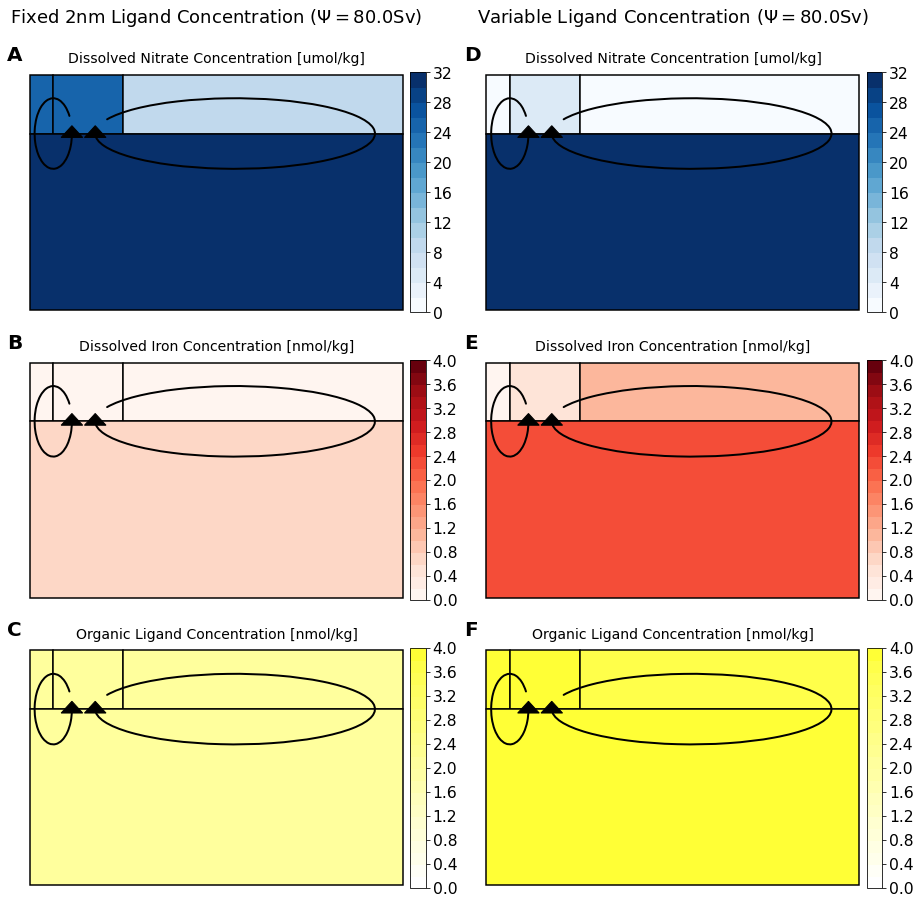

In [137]:
# Create a Rectangle patch
tstep = -1

patches = {
    "AA" : {
        "x"  : 0.00,
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "SO" : {
        "x"  : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][1] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "NA" : {
        "x" : (ensemble1_input["dy"].iloc[0][0] + ensemble1_input["dy"].iloc[0][1])
             / ensemble1_input["dy"].iloc[0][3],
        "y"  : 0.75,
        "dx" : ensemble1_input["dy"].iloc[0][2] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.25,
    },
    "DO" : {
        "x"  : 0.0,
        "y"  : 0.0,
        "dx" : ensemble1_input["dy"].iloc[0][3] / ensemble1_input["dy"].iloc[0][3],
        "dy" : 0.75,
    },
    "AMOC" : {
        "x"     : 0.55,
        "y"     : 0.75,
        "dx"    : 0.75,
        "dy"    : 0.3,
        "angle" : 0,
        "start" : 180,
        "end"   : 170,
    },
    "AABW" : {
        "x"     : ensemble1_input["dy"].iloc[0][0] / ensemble1_input["dy"].iloc[0][3],
        "y"     : 0.75,
        "dx" : 0.1,
        "dy" : 0.3,
        "angle" : 0,
        "start" : 60,
        "end"   : 360,
    },
}

plot_vars = {
    "n" : {
        "max"    : 32,
        "min"    : 0,
        "bounds" : np.arange(0, 34, 2),
        "cmap"   : plt.cm.get_cmap("Blues").copy(),
        "title"  : "Dissolved Nitrate Concentration [umol/kg]",   
        },
    "f": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : plt.cm.get_cmap("Reds").copy(),
        "title"  : "Dissolved Iron Concentration [nmol/kg]",
    },
    "l": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : mp.colors.ListedColormap( 
                        mp.cm.get_cmap("hot_r")( 
                            np.linspace( 
                                0.0, 0.2, len(np.arange(0, 4.2, 0.2))
                            ),
                        )),
                "title"  : "Organic Ligand Concentration [nmol/kg]",
    },
}

boxargs = {
         "linewidth" : 1.5,
         "edgecolor" : "black",
        }

arcargs = {
         "capstyle"  : 'round',
         "linestyle" : '-',
         "linewidth" : 2,
         "color"     : "black",
        }

model_output  = [ensemble1_output,  ensemble2_output ]
model_anomaly = [ensemble1_anomaly, ensemble2_anomaly]

f9, f9ax = plt.subplots(figsize=(15, 15), ncols=2, nrows=3)
f9.patch.set_facecolor("None")
f9ca = f9ax.copy()
f9cb = f9ax.copy()

for mm in np.arange(len(model_output)):
    for ii, chem in enumerate(plot_vars.keys()):
        f9ax[ii, mm].axes.get_xaxis().set_visible(False)
        f9ax[ii, mm].get_yaxis().set_visible(False)
        f9ax[ii, mm].set_facecolor((1, 1, 1, 0))
        f9ax[ii, mm].set_axis_off()

        norm = mp.colors.BoundaryNorm(
            plot_vars[chem]["bounds"],
            plot_vars[chem]["cmap"].N,
        )
        mycmp = plt.cm.ScalarMappable(
            norm=norm,
            cmap=plot_vars[chem]["cmap"],
        )
        
        aapatch = Rectangle(
                (patches["AA"]["x"], patches["AA"]["y"]),
                patches["AA"]["dx"],
                patches["AA"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "aa"]),
                **boxargs,
        )
        sopatch = Rectangle(
                (patches["SO"]["x"], patches["SO"]["y"]),
                patches["SO"]["dx"],
                patches["SO"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "so"]),
                **boxargs,
        )
        napatch = Rectangle(
                (patches["NA"]["x"], patches["NA"]["y"]),
                patches["NA"]["dx"],
                patches["NA"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "na"]),
                **boxargs,
        )
        dopatch = Rectangle(
                (patches["DO"]["x"], patches["DO"]["y"]),
                patches["DO"]["dx"],
                patches["DO"]["dy"],
                facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + "do"]),
                **boxargs,
        )     

        amocarc = Arc(
                [patches["AMOC"]["x"], patches["AMOC"]["y"]],
                patches["AMOC"]["dx"],
                patches["AMOC"]["dy"],
                angle  = patches["AMOC"]["angle"],
                theta1 = patches["AMOC"]["start"],
                theta2 = patches["AMOC"]["end"],
                **arcargs,
        )

        aabwarc = Arc(
                [patches["AABW"]["x"], patches["AABW"]["y"]],
                patches["AABW"]["dx"],
                patches["AABW"]["dy"],
                angle  = patches["AABW"]["angle"],
                theta1 = patches["AABW"]["start"],
                theta2 = patches["AABW"]["end"],
                **arcargs,
        )
        
        amocarrow = RegularPolygon(
                (
                 patches["AMOC"]["x"]+(patches["AMOC"]["dx"]/2)*
                    np.cos(np.radians(patches["AMOC"]["start"]+patches["AMOC"]["angle"])), 
                 patches["AMOC"]["y"]+(patches["AMOC"]["dy"]/2)*
                    np.sin(np.radians(patches["AMOC"]["start"]+patches["AMOC"]["angle"]))
                ),           
                orientation = np.radians(patches["AMOC"]["angle"]+patches["AMOC"]["start"]+180),     
                radius      = patches["AMOC"]["dy"]/9,
                numVertices = 3,
                color       = arcargs["color"]
        )
        
        aabwarrow = RegularPolygon(
                (
                 patches["AABW"]["x"]+(patches["AABW"]["dx"]/2)*
                    np.cos(np.radians(patches["AABW"]["end"]+patches["AABW"]["angle"])), 
                 patches["AABW"]["y"]+(patches["AABW"]["dy"]/2)*
                    np.sin(np.radians(patches["AABW"]["end"]+patches["AABW"]["angle"]))
                ),           
                orientation = np.radians(patches["AABW"]["angle"]+patches["AABW"]["end"]),     
                radius      = patches["AABW"]["dy"]/9,
                numVertices = 3,
                color       = arcargs["color"]
        )
            
        for patch in [aapatch, sopatch, napatch, dopatch, amocarc, amocarrow, aabwarc, aabwarrow]:
            f9ax[ii, mm].add_patch(patch)

        f9ax[ii, mm].set(
            xlim = (-0.01, 1.01),
            ylim = (-0.01, 1.01),
        )

        if ii==0 and mm == 0:
            title_text = "Fixed 2nm Ligand Concentration ($\Psi=${0}Sv)\n\n" \
                .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
            f9ax[ii,mm].set_title(title_text, fontsize=18)
        elif ii==0 and mm==1:
            title_text = "Variable Ligand Concentration ($\Psi=${0}Sv)\n\n" \
                .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
            f9ax[ii,mm].set_title(title_text, fontsize=18)

        f9ax[ii, mm].text(
            0.5,
            1.05,
            plot_vars[chem]["title"],
            fontsize            = 14,
            horizontalalignment = "center",
        )

        # Add a colorbar to the model sections
        f9ca[ii, mm] = inset_axes(
            f9ax[ii, mm],
            width          = "4%",
            height         = "100%",
            bbox_to_anchor = (0.05, 0, 1, 1),
            bbox_transform = f9ax[ii, mm].transAxes,
            borderpad      = 0,
        )
        
        f9cb[ii, mm] = f9.colorbar(
            mycmp,
            cax         = f9ca[ii, mm],
            orientation = "vertical",
            ticks       = plot_vars[chem]["bounds"][::2],
        )
        
        f9cb[ii, mm].solids.set_edgecolor("face")
            
label_axes(f9ax,label_columns=True)
plt.show()
# save the graph
f9.savefig(
    "microCOSM_ensemble_psi_{0:.0f}Sv_sections.pdf".format(model_output[mm]["psi"].iloc[tstep]*1e-6),
    facecolor   = f9.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)